In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
from langchain_groq import ChatGroq

# Get API key from environment
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("❌ GROQ_API_KEY is not set. Please export it before running.")

# Initialize Groq LLM
llm = ChatGroq(
    model="llama3-8b-8192", 
    api_key=GROQ_API_KEY, 
    temperature=0
)


In [ ]:
import pandas as pd
import gradio as gr
from langchain_groq import ChatGroq
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document
from dotenv import load_dotenv
import os
import re
from datetime import datetime

# Load environment variables
load_dotenv(override=True)

# -----------------------------
# Global Variables
# -----------------------------
vector_db = None
pdf_content = ""
csv_data = None
pdf_vector_db = None  # Separate vector DB for PDF content

# -----------------------------
# Helper Functions for Patient Data Retrieval
# -----------------------------
def search_by_id(patient_id):
    """Search for patient by ID - exact match"""
    global csv_data
    if csv_data is None:
        return None
    
    # Convert to string and strip whitespace
    search_id = str(patient_id).strip()
    print(f"🆔 Searching for patient ID: {search_id}")
    
    # Search in CSV
    matching_patients = csv_data[csv_data['patient_id'].astype(str).str.strip() == search_id]
    
    if not matching_patients.empty:
        patient = matching_patients.iloc[0].to_dict()
        print(f"✅ Found patient by ID: {search_id} - Name: {patient['patient_name']}")
        return patient
    
    print(f"❌ No patient found with ID: {search_id}")
    return None

def search_by_name(name):
    """Search for patient by name - flexible matching"""
    global csv_data
    if csv_data is None:
        return None
    
    search_name = name.lower().strip()
    print(f"👤 Searching for patient name: '{search_name}'")
    
    for _, row in csv_data.iterrows():
        patient_name = str(row['patient_name']).lower().strip()
        
        # Method 1: Exact name match
        if patient_name == search_name:
            print(f"✅ Exact name match found: {patient_name}")
            return row.to_dict()
        
        # Method 2: Name contains search term
        if search_name in patient_name:
            print(f"✅ Partial name match found: {patient_name}")
            return row.to_dict()
        
        # Method 3: Search term contains name
        if patient_name in search_name:
            print(f"✅ Name contained in search: {patient_name}")
            return row.to_dict()
        
        # Method 4: Check individual name parts
        name_parts = patient_name.split()
        search_parts = search_name.split()
        
        for name_part in name_parts:
            if len(name_part) > 2:  # Ignore very short parts
                for search_part in search_parts:
                    if name_part == search_part:
                        print(f"✅ Name part match found: {name_part}")
                        return row.to_dict()
    
    print(f"❌ No patient found with name: '{search_name}'")
    return None

def get_patient_data(query):
    """Main function to automatically find patient data from query"""
    global csv_data
    if csv_data is None:
        print("❌ CSV data not loaded")
        return None
    
    query_lower = query.lower().strip()
    print(f"🔍 Processing query: '{query_lower}'")
    
    # Strategy 1: Look for ID patterns (numbers in the query)
    id_patterns = [r'id\s*(\d+)', r'patient\s*(\d+)', r'\bid\s*(\d+)', r'(\d+)']
    
    for pattern in id_patterns:
        match = re.search(pattern, query_lower)
        if match:
            patient_id = match.group(1)
            print(f"🔢 Found ID pattern: {patient_id}")
            patient = search_by_id(patient_id)
            if patient:
                return patient
    
    # Strategy 2: Look for name patterns
    # Remove common words that aren't names
    name_stopwords = ['patient', 'with', 'id', 'about', 'tell', 'me', 'show', 'get', 'find', 'data', 'of', 'for', 'the', 'a', 'an', 'what', 'who', 'is', 'are', 'condition', 'symptoms', 'information']
    
    # Clean the query to extract potential names
    query_words = query_lower.split()
    potential_names = []
    
    for word in query_words:
        clean_word = re.sub(r'[^\w]', '', word)  # Remove punctuation
        if len(clean_word) > 2 and clean_word not in name_stopwords and not clean_word.isdigit():
            potential_names.append(clean_word)
    
    # Try each potential name
    for name in potential_names:
        print(f"🔍 Trying name: '{name}'")
        patient = search_by_name(name)
        if patient:
            return patient
    
    # Try the full cleaned query as a name
    if potential_names:
        full_name = ' '.join(potential_names)
        print(f"🔍 Trying full name: '{full_name}'")
        patient = search_by_name(full_name)
        if patient:
            return patient
    
    # Strategy 3: Look for conditions
    conditions = ['autism', 'adhd', 'anxiety', 'depression', 'speech delay', 'ocd', 'bipolar', 'asperger']
    for condition in conditions:
        if condition in query_lower:
            print(f"🔍 Searching for condition: {condition}")
            matching_patients = csv_data[csv_data['patient_data'].str.lower().str.contains(condition, na=False)]
            if not matching_patients.empty:
                print(f"✅ Found {len(matching_patients)} patients with condition: {condition}")
                return matching_patients.to_dict('records')
    
    print("❌ No patient data found for this query")
    return None

# -----------------------------
# Setup Vector Database
# -----------------------------
def setup_vector_db():
    """Setup vector database from CSV file"""
    global vector_db, csv_data
    
    try:
        csv_file = "autism_data.csv"
        if not os.path.exists(csv_file):
            print(f"❌ CSV file {csv_file} not found!")
            return None
        
        csv_data = pd.read_csv(csv_file)
        print(f"📊 CSV loaded: {len(csv_data)} rows")
        
        # Create documents for vector database
        documents = []
        for idx, row in csv_data.iterrows():
            content = f"""Patient ID: {row['patient_id']}
Patient Name: {row['patient_name']}
Gender: {row['gender']}
Patient Data: {row['patient_data']}
Medical Suggestion: {row['suggestion']}"""
            
            doc = Document(
                page_content=content,
                metadata={"patient_id": str(row['patient_id']), "patient_name": str(row['patient_name'])}
            )
            documents.append(doc)
        
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vector_db = FAISS.from_documents(documents, embeddings)
        print(f"✅ Vector database created with {len(documents)} patient records")
        return vector_db
        
    except Exception as e:
        print(f"❌ Vector DB setup failed: {e}")
        return None

def setup_pdf_vector_db():
    """Setup separate vector database for PDF content"""
    global pdf_vector_db, pdf_content
    
    try:
        pdf_file = "Auticare_chatbot_comprehensivepdf.pdf"
        
        if not os.path.exists(pdf_file):
            print(f"❌ PDF file {pdf_file} not found!")
            return None
            
        # Load PDF content
        loader = PyPDFLoader(pdf_file)
        documents = loader.load()
        
        # Split into smaller chunks for better retrieval
        pdf_documents = []
        for doc in documents:
            content = doc.page_content
            # Split into chunks of ~500 characters
            chunk_size = 500
            chunks = [content[i:i+chunk_size] for i in range(0, len(content), chunk_size)]
            
            for i, chunk in enumerate(chunks):
                if len(chunk.strip()) > 50:  # Only keep meaningful chunks
                    pdf_doc = Document(
                        page_content=chunk,
                        metadata={"source": "autism_pdf", "page": doc.metadata.get("page", 0), "chunk": i}
                    )
                    pdf_documents.append(pdf_doc)
        
        # Create vector database for PDF
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        pdf_vector_db = FAISS.from_documents(pdf_documents, embeddings)
        
        # Also store the full content
        pdf_content = "\n\n".join([doc.page_content for doc in documents])
        
        print(f"✅ PDF Vector DB created with {len(pdf_documents)} chunks from {len(documents)} pages")
        return pdf_vector_db
        
    except Exception as e:
        print(f"❌ PDF Vector DB setup failed: {e}")
        return None

# -----------------------------
# Tools
# -----------------------------
@tool
def patient_data_retrieval_tool(query: str) -> str:
    """
    Find patient data by ID or name and return complete patient information.
    """
    print(f"🔍 Searching for patient data in query: '{query}'")
    
    patient_data = get_patient_data(query)
    
    if patient_data is None:
        return "No patient found for this query."
    
    # Single patient found
    if isinstance(patient_data, dict):
        # Return ALL patient data to LLM
        patient_info = f"""Complete Patient Information:

Patient ID: {patient_data['patient_id']}
Patient Name: {patient_data['patient_name']}
Gender: {patient_data['gender']}
Patient Data: {patient_data['patient_data']}
Medical Suggestion: {patient_data['suggestion']}

This is all the available information for this patient. Answer the user's question based on this data."""
        
        print(f"✅ Found single patient: {patient_data['patient_name']} (ID: {patient_data['patient_id']})")
        return patient_info
    
    # Multiple patients found (for condition searches)
    elif isinstance(patient_data, list):
        result = f"Found {len(patient_data)} patients. Here is their complete information:\n\n"
        
        for i, patient in enumerate(patient_data, 1):
            result += f"Patient {i}:\n"
            result += f"ID: {patient['patient_id']}\n"
            result += f"Name: {patient['patient_name']}\n"
            result += f"Gender: {patient['gender']}\n"
            result += f"Patient Data: {patient['patient_data']}\n"
            result += f"Medical Suggestion: {patient['suggestion']}\n\n"
        
        result += "Answer the user's question based on this patient information."
        print(f"✅ Found {len(patient_data)} patients")
        return result
    
    return "No relevant patient information found."

@tool
def autism_knowledge_tool(query: str) -> str:
    """
    Retrieve relevant autism knowledge from PDF using vector search.
    """
    print(f"📚 Searching PDF knowledge for: {query}")
    
    global pdf_vector_db
    if pdf_vector_db is None:
        return "Medical knowledge base not available."
    
    try:
        # Use vector search to find relevant content
        relevant_docs = pdf_vector_db.similarity_search(query, k=5)  # Get top 5 relevant chunks
        
        if relevant_docs:
            knowledge_content = "RELEVANT MEDICAL KNOWLEDGE FROM PDF:\n\n"
            for i, doc in enumerate(relevant_docs, 1):
                knowledge_content += f"Reference {i}:\n{doc.page_content}\n\n"
            
            print(f"✅ Found {len(relevant_docs)} relevant PDF sections")
            return knowledge_content
        else:
            return "No relevant medical knowledge found in PDF."
            
    except Exception as e:
        print(f"❌ Error retrieving PDF knowledge: {e}")
        return "Error accessing medical knowledge base."

# -----------------------------
# Setup LLM
# -----------------------------
def setup_llm():
    """Setup LLM with tools"""
    try:
        api_key = os.getenv("GROQ_API_KEY")
        if not api_key:
            print("❌ GROQ_API_KEY not found in environment")
            return None
            
        base_llm = ChatGroq(
            model="llama3-8b-8192", 
            api_key=api_key,
            temperature=0.1
        )
        
        llm_with_tools = base_llm.bind_tools([patient_data_retrieval_tool, autism_knowledge_tool])
        print("✅ LLM initialized with tools")
        return llm_with_tools
        
    except Exception as e:
        print(f"❌ LLM setup failed: {e}")
        return None

# Initialize system
print("🚀 Setting up Autism Chatbot System...")
vector_db = setup_vector_db()
pdf_vector_db = setup_pdf_vector_db()
llm = setup_llm()

# -----------------------------
# State Schema
# -----------------------------
class ChatbotState(TypedDict):
    query: str
    query_type: str
    patient_data: str
    medical_knowledge: str
    final_response: str
    chat_history: List[Dict]

# -----------------------------
# Node Functions
# -----------------------------
def classify_query_type(state: ChatbotState):
    """Classify the query to determine processing approach"""
    query = state["query"].lower()
    
    # Check for greetings
    greetings = ['hi', 'hello', 'hey', 'good morning', 'good afternoon', 'good evening']
    if any(greeting in query for greeting in greetings) and len(query.split()) <= 3:
        return {"query_type": "greeting"}
    
    # Check if query might contain patient information (ID, name, condition)
    patient_indicators = [
        r'\b\d+\b',  # Any number (could be patient ID)
        'patient', 'name', 'id'
    ]
    
    # Check for specific patient-related terms
    if any(re.search(indicator, query) for indicator in patient_indicators):
        return {"query_type": "patient_related"}
    
    # Check for patient names or conditions in query
    patient_terms = ['john', 'pamela', 'sarah', 'mike', 'lisa', 'autism', 'adhd', 'anxiety', 'depression']
    if any(term in query for term in patient_terms):
        return {"query_type": "patient_related"}
    
    return {"query_type": "general_autism"}

def handle_greeting(state: ChatbotState):
    """Handle greeting messages"""
    return {
        "final_response": "Hello! I'm your autism specialist assistant. I can help you with patient information, autism questions, and medical guidance. How can I help you today?"
    }

def retrieve_patient_data(state: ChatbotState):
    """Retrieve patient data based on query"""
    query = state["query"]
    
    try:
        patient_info = patient_data_retrieval_tool.invoke({"query": query})
        return {"patient_data": patient_info}
    except Exception as e:
        return {"patient_data": f"Error retrieving patient data: {str(e)}"}

def get_medical_knowledge(state: ChatbotState):
    """Get medical/autism knowledge from PDF"""
    query = state["query"]
    
    try:
        knowledge = autism_knowledge_tool.invoke({"query": query})
        return {"medical_knowledge": knowledge}
    except Exception as e:
        return {"medical_knowledge": f"Error retrieving medical knowledge: {str(e)}"}

def generate_response(state: ChatbotState):
    """Generate final response using LLM with all available data and chat history"""
    
    if not llm:
        return {"final_response": "❌ LLM not available. Please configure your API key."}
    
    query = state["query"]
    query_type = state.get("query_type", "")
    chat_history = state.get("chat_history", [])
    
    # Handle greetings directly
    if query_type == "greeting":
        return handle_greeting(state)
    
    # Prepare context for LLM
    context_parts = []
    
    # Add chat history for conversational memory
    if chat_history:
        history_context = "CONVERSATION MEMORY (what we discussed before):\n"
        for item in chat_history[-5:]:  # Last 5 exchanges
            history_context += f"Previous User Query: {item['user']}\nPrevious My Response: {item['assistant']}\n---\n"
        context_parts.append(history_context)
    
    # Add patient data if available
    patient_data = state.get("patient_data", "")
    if patient_data and "Error" not in patient_data and "No patient found" not in patient_data:
        context_parts.append(f"CURRENT PATIENT DATA:\n{patient_data}")
    
    # Add medical knowledge if available  
    medical_knowledge = state.get("medical_knowledge", "")
    if medical_knowledge and "Error" not in medical_knowledge and "not available" not in medical_knowledge:
        context_parts.append(f"MEDICAL KNOWLEDGE FROM PDF:\n{medical_knowledge}")
    
    # Create prompt for LLM with memory instructions
    if context_parts:
        context = "\n\n".join(context_parts)
        prompt = f"""You are an autism specialist assistant with conversational memory. Give direct, concise answers.

{context}

CURRENT USER QUESTION: {query}

INSTRUCTIONS:
- Give SHORT, DIRECT answers - maximum 3-4 sentences
- Don't repeat information already provided
- When user says "that patient", "him/her", "they" - refer to previously mentioned patients
- Only mention previous conversation if directly relevant
- Don't over-explain or be repetitive
- Answer exactly what was asked

RESPONSE (keep it brief and focused):"""
    else:
        # Try to get medical knowledge even without patient data
        try:
            knowledge = autism_knowledge_tool.invoke({"query": query})
            if knowledge and "Error" not in knowledge and "not available" not in knowledge:
                context = f"MEDICAL KNOWLEDGE FROM PDF:\n{knowledge}"
                
                # Include history even when no specific patient data
                history_text = ""
                if chat_history:
                    history_text = "\nCONVERSATION MEMORY:\n"
                    for item in chat_history[-3:]:
                        history_text += f"Previous: User asked '{item['user']}', I responded about: {item['assistant'][:100]}...\n"
                
                prompt = f"""You are an autism specialist assistant with conversational memory.

{context}{history_text}

CURRENT USER QUESTION: {query}

Respond naturally, referencing our previous conversation if relevant. Use the medical knowledge provided.

RESPONSE:"""
            else:
                prompt = f"""You are an autism specialist assistant.

USER QUESTION: {query}

I can provide general autism guidance, though specific database information may not be available right now.

RESPONSE:"""
        except:
            prompt = f"""You are an autism specialist assistant.

USER QUESTION: {query}

Please provide helpful autism-related information.

RESPONSE:"""
    
    try:
        # Use base LLM for final response
        from langchain_groq import ChatGroq
        base_llm = ChatGroq(
            model="llama3-8b-8192", 
            api_key=os.getenv("GROQ_API_KEY"),
            temperature=0.3  # Slightly higher for more natural conversation
        )
        response = base_llm.invoke(prompt)
        return {"final_response": response.content}
        
    except Exception as e:
        return {"final_response": f"❌ Error generating response: {str(e)}"}

# -----------------------------
# Routing Functions
# -----------------------------
def route_after_classification(state: ChatbotState) -> str:
    """Route based on query type"""
    query_type = state.get("query_type", "general_autism")
    
    if query_type == "greeting":
        return "generate_response"
    elif query_type == "patient_related":
        return "retrieve_patient"
    else:
        return "get_knowledge"

# -----------------------------
# Build LangGraph
# -----------------------------
graph = StateGraph(ChatbotState)

# Add nodes
graph.add_node("classify", classify_query_type)
graph.add_node("retrieve_patient", retrieve_patient_data)
graph.add_node("get_knowledge", get_medical_knowledge)
graph.add_node("generate_response", generate_response)

# Set entry point
graph.set_entry_point("classify")

# Add conditional edges
graph.add_conditional_edges(
    "classify",
    route_after_classification,
    {
        "generate_response": "generate_response",
        "retrieve_patient": "retrieve_patient", 
        "get_knowledge": "get_knowledge"
    }
)

# Add edges to final response
graph.add_edge("retrieve_patient", "generate_response")
graph.add_edge("get_knowledge", "generate_response")
graph.add_edge("generate_response", END)

# Compile graph
app = graph.compile()

# -----------------------------
# Main Chat Function
# -----------------------------
def ask_chatbot(query: str, chat_history: List[Dict] = None):
    """Main function to process user queries through LangGraph"""
    
    if chat_history is None:
        chat_history = []
    
    initial_state = ChatbotState(
        query=query,
        query_type="",
        patient_data="",
        medical_knowledge="",
        final_response="",
        chat_history=chat_history
    )
    
    try:
        result = app.invoke(initial_state)
        return result.get("final_response", "I couldn't process your request. Please try again.")
        
    except Exception as e:
        print(f"Error in chatbot processing: {e}")
        return "I'm sorry, I encountered an error. Please try asking your question again."

# -----------------------------
# Chatbot Class for Gradio Interface with History
# -----------------------------
class AutismChatbot:
    def __init__(self):
        self.name = "Autism Specialist Assistant"
        self.conversation_history = []  # Store last 5 conversations

    def system_prompt(self):
        return f"""You are {self.name}, specializing in autism and developmental disorders.

INSTRUCTIONS:
- Answer autism-related questions using patient data and medical knowledge from PDF
- Use conversation history for context
- Be precise and helpful
- If asking about specific patients, provide their complete information
- Always recommend consulting healthcare professionals for medical decisions
- Keep responses concise but informative"""

    def chat(self, message, history):
        """Chat interface with conversational memory for the chatbot"""
        if history is None:
            history = []
        
        if not message.strip():
            return "Please ask me something about autism or patient information."
        
        try:
            # Get response from our LangGraph system with history
            response = ask_chatbot(message, self.conversation_history)
            
            # Store this conversation in the chatbot's memory (keep last 5)
            self.conversation_history.append({
                "user": message,
                "assistant": response,
                "timestamp": datetime.now().isoformat()
            })
            
            # Keep only last 5 conversations for memory
            if len(self.conversation_history) > 5:
                self.conversation_history = self.conversation_history[-5:]
            
            return response
            
        except Exception as e:
            print(f"Chat error: {e}")
            return "I'm having trouble right now. Please try asking your question again."

    def get_memory_summary(self):
        """Get a summary of what the chatbot remembers"""
        if not self.conversation_history:
            return "I don't have any conversation memory yet."
        
        summary = "Here's what I remember from our conversation:\n\n"
        for i, item in enumerate(self.conversation_history, 1):
            summary += f"{i}. You asked: {item['user'][:50]}{'...' if len(item['user']) > 50 else ''}\n"
            summary += f"   I discussed: {item['assistant'][:100]}{'...' if len(item['assistant']) > 100 else ''}\n\n"
        
        return summary

# -----------------------------
# Create Interface
# -----------------------------
autism_chatbot = AutismChatbot()

# Create the chat interface with additional functionality
with gr.Blocks(title="🧠 Autism Specialist Chatbot") as iface:
    gr.Markdown("# 🧠 Autism Specialist Chatbot")
    gr.Markdown("Ask about autism, patient information, treatments, or medical guidance. I have access to patient database and medical knowledge from PDF.")
    
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="Ask me about autism, patients, or medical questions...")
    
    with gr.Row():
        clear_btn = gr.Button("Clear Chat")
        memory_btn = gr.Button("What do you remember?")
        clear_memory_btn = gr.Button("Clear My Memory")
    
    # Example questions
    gr.Examples(
        examples=[
            "Hi there",
            "Can I get patient with id 992?",
            "What about patient John?", 
            "Tell me more about that patient",
            "What are his symptoms?",
            "What treatment do you suggest for her?",
            "Show me patients with autism",
            "What are autism symptoms?",
            "What treatments are available?",
            "Tell me about the patient we discussed earlier"
        ],
        inputs=msg
    )

    def respond(message, chat_history):
        response = autism_chatbot.chat(message, chat_history)
        chat_history.append((message, response))
        return "", chat_history
    
    def clear_chat():
        return None, ""
    
    def show_memory():
        memory_summary = autism_chatbot.get_memory_summary()
        return [(f"What do you remember about our conversation?", memory_summary)]
    
    def clear_memory():
        autism_chatbot.clear_history()
        return [(f"Please forget our previous conversation", "I've cleared my memory. I no longer remember our previous conversation. How can I help you with autism-related questions?")]
    
    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear_btn.click(clear_chat, outputs=[chatbot, msg])
    memory_btn.click(show_memory, outputs=[chatbot])
    clear_memory_btn.click(clear_memory, outputs=[chatbot])

    def clear_history(self):
        """Clear conversation memory"""
        self.conversation_history = []
        return "My memory has been cleared!"

# -----------------------------
# Testing Function
# -----------------------------
def run_tests():
    """Test the chatbot with history and PDF functionality"""
    print("🧪 TESTING ENHANCED CHATBOT - PDF + HISTORY")
    print("=" * 60)
    
    # Test queries
    test_queries = [
        "Hi there",
        "What are autism symptoms?",  # Should use PDF
        "Can I get patient with id 992?",  # Should use patient data
        "What are his symptoms?",  # Should remember the patient from previous query
        "What treatment do you recommend for that patient?",  # Should use memory + PDF
        "Tell me about a different patient - John",  # New patient
        "Compare the two patients we discussed",  # Should remember both patients
    ]
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n🔸 Test {i}: {query}")
        print("─" * 30)
        try:
            response = autism_chatbot.chat(query, [])
            print(f"🤖 Response: {response}")
        except Exception as e:
            print(f"❌ Error: {e}")
        print("=" * 60)

# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    print("🚀 Enhanced Autism Chatbot is ready!")
    print("✅ Features: PDF Knowledge Base + 5-Message History + Patient Database")
    
    # Uncomment to run tests
    # run_tests()
    
    iface.launch()  # Let Gradio find an available port automatically

/home/venkat_chiranjeevi/project/linuxbro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Setting up Autism Chatbot System...
📊 CSV loaded: 1000 rows


/tmp/ipykernel_1578/498418296.py:186: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


✅ Vector database created with 1000 patient records
✅ PDF Vector DB created with 301 chunks from 39 pages
✅ LLM initialized with tools
🚀 Enhanced Autism Chatbot is ready!
✅ Features: PDF Knowledge Base + 5-Message History + Patient Database


/tmp/ipykernel_1578/498418296.py:664: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


🔍 Searching for patient data in query: 'can i get patien name with 45.'
🔍 Processing query: 'can i get patien name with 45.'
🔢 Found ID pattern: 45
🆔 Searching for patient ID: 45
✅ Found patient by ID: 45 - Name: Aila
✅ Found single patient: Aila (ID: 45)
🔍 Searching for patient data in query: 'patient id 36 name'
🔍 Processing query: 'patient id 36 name'
🔢 Found ID pattern: 36
🆔 Searching for patient ID: 36
✅ Found patient by ID: 36 - Name: Magdalen
✅ Found single patient: Magdalen (ID: 36)
📚 Searching PDF knowledge for: What are his symptoms?
✅ Found 5 relevant PDF sections


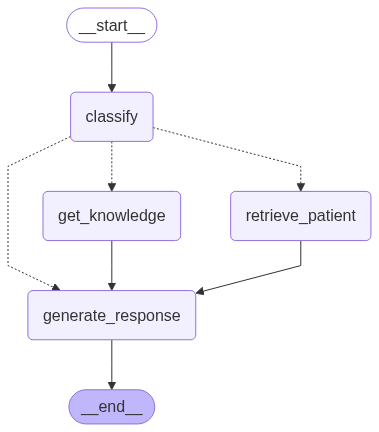

In [5]:
from IPython.display import Image
graph = app.get_graph()   # app is your compiled LangGraph
Image(graph.draw_mermaid_png())
